In [1]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

# Importing train dataset

In [2]:
train_data=pd.read_csv('/root/bert_train_df.csv')

In [3]:
train_data=train_data[['text','anger','anticipation','disgust','fear','joy', 'love','optimism','pessimism','sadness','surprise','trust']]

In [4]:
train_data=train_data.dropna()

In [51]:
train_data.head()

,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,_kellerman it also helps that the majority of...,1,0,1,0,1,0,1,0,0,0,0
3,accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,my roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
max_length = 70
# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

# Preparing the input and output layers to train the model

In [7]:
# Load the MainLayer
bert = transformer_model.layers[0]
# Build model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
# model output
anger = Dense(units=len(train_data.anger.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='anger')(pooled_output)
fear = Dense(units=len(train_data.anger.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='fear')(pooled_output)
disgust = Dense(units=len(train_data.anger.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='disgust')(pooled_output)
joy = Dense(units=len(train_data.joy.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='joy')(pooled_output)
optimism = Dense(units=len(train_data.anger.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='optimism')(pooled_output)
sadness = Dense(units=len(train_data.joy.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='sadness')(pooled_output)
surprise = Dense(units=len(train_data.anger.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='surprise')(pooled_output)
love = Dense(units=len(train_data.joy.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='love')(pooled_output)
outputs = {'anger': anger, 'joy': joy,  'fear':fear,'disgust':disgust,'optimism':optimism,'sadness':sadness,'surprise':surprise,'love':love}
# combine all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')
# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 70)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][1]                       
__________________________________________________________________________________________________
anger (Dense)                   (None, 2)            1538        pooled_output[0][0]              
_________________________________________________________________________

# Training the model

In [8]:
# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = {'joy': CategoricalCrossentropy(from_logits = True), 'anger': CategoricalCrossentropy(from_logits = True),'fear': CategoricalCrossentropy(from_logits = True), 'disgust': CategoricalCrossentropy(from_logits = True),'optimism': CategoricalCrossentropy(from_logits = True), 'love': CategoricalCrossentropy(from_logits = True),'sadness': CategoricalCrossentropy(from_logits = True), 'surprise': CategoricalCrossentropy(from_logits = True)}
metric = {'joy': CategoricalAccuracy('accuracy'), 'anger': CategoricalAccuracy('accuracy'),'fear': CategoricalAccuracy('accuracy'), 'disgust': CategoricalAccuracy('accuracy'),'optimism': CategoricalAccuracy('accuracy'), 'love': CategoricalAccuracy('accuracy'),'sadness': CategoricalAccuracy('accuracy'), 'surprise': CategoricalAccuracy('accuracy')}
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)
# Ready output data for the model
y_joy = to_categorical(train_data['joy'])
y_anger = to_categorical(train_data['anger'])
y_fear = to_categorical(train_data['fear'])
y_disgust = to_categorical(train_data['disgust'])
y_optimism = to_categorical(train_data['optimism'])
y_love = to_categorical(train_data['love'])
y_sadness = to_categorical(train_data['sadness'])
y_surprise = to_categorical(train_data['surprise'])
# Tokenize the input 
x = tokenizer(
    text=train_data['text'].tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'anger': y_anger, 'joy': y_joy,  'fear':y_fear,'disgust':y_disgust,'optimism':y_optimism,'sadness':y_sadness,'surprise':y_surprise,'love':y_love},
    validation_split=0.2,
    batch_size=64,
    epochs=10)

Epoch 1/10
86/86 [==============================] - 331s 4s/step - loss: 4.4624 - anger_loss: 0.7012 - disgust_loss: 0.6681 - fear_loss: 0.4946 - joy_loss: 0.6830 - love_loss: 0.3944 - optimism_loss: 0.6044 - sadness_loss: 0.6221 - surprise_loss: 0.2946 - anger_accuracy: 0.5671 - disgust_accuracy: 0.6167 - fear_accuracy: 0.8186 - joy_accuracy: 0.5854 - love_accuracy: 0.8614 - optimism_accuracy: 0.7122 - sadness_accuracy: 0.6927 - surprise_accuracy: 0.9040 - val_loss: 4.1985 - val_anger_loss: 0.6483 - val_disgust_loss: 0.6642 - val_fear_loss: 0.4996 - val_joy_loss: 0.6552 - val_love_loss: 0.3180 - val_optimism_loss: 0.6131 - val_sadness_loss: 0.5982 - val_surprise_loss: 0.2018 - val_anger_accuracy: 0.6389 - val_disgust_accuracy: 0.6170 - val_fear_accuracy: 0.8012 - val_joy_accuracy: 0.6404 - val_love_accuracy: 0.9028 - val_optimism_accuracy: 0.6923 - val_sadness_accuracy: 0.7127 - val_surprise_accuracy: 0.9488
Epoch 2/10
86/86 [==============================] - 289s 3s/step - loss: 3.80

Epoch 10/10
86/86 [==============================] - 273s 3s/step - loss: 1.4193 - anger_loss: 0.1480 - disgust_loss: 0.2472 - fear_loss: 0.1260 - joy_loss: 0.1752 - love_loss: 0.1381 - optimism_loss: 0.2037 - sadness_loss: 0.2356 - surprise_loss: 0.1455 - anger_accuracy: 0.9427 - disgust_accuracy: 0.8988 - fear_accuracy: 0.9608 - joy_accuracy: 0.9406 - love_accuracy: 0.9447 - optimism_accuracy: 0.9245 - sadness_accuracy: 0.9098 - surprise_accuracy: 0.9531 - val_loss: 2.8606 - val_anger_loss: 0.4138 - val_disgust_loss: 0.4730 - val_fear_loss: 0.2733 - val_joy_loss: 0.3480 - val_love_loss: 0.2301 - val_optimism_loss: 0.4329 - val_sadness_loss: 0.5204 - val_surprise_loss: 0.1691 - val_anger_accuracy: 0.8443 - val_disgust_accuracy: 0.7997 - val_fear_accuracy: 0.8984 - val_joy_accuracy: 0.8692 - val_love_accuracy: 0.8984 - val_optimism_accuracy: 0.8121 - val_sadness_accuracy: 0.7917 - val_surprise_accuracy: 0.9532


# to predict dataset

In [9]:
data_test=pd.read_csv('/root/london_tr.csv')


** Translate Tweets to english **

In [ ]:
def translate(t):
    t=str(t)[0:3000]
    translated = GoogleTranslator(source='auto', target='en').translate(t)
    return translated

for i in range(len(df2)):
    if (len(data_test.loc[i,"text"])>1) and (len(data_test.loc[i,"text"])<3000):
        data_test.loc[i,"text"] = translate(data_test.loc[i,"text"])

# Cleaning data

In [10]:
import regex as re
from deep_translator import GoogleTranslator
import emoji
def translate(t):
    t=str(t)[0:3000]
    translated = GoogleTranslator(source='auto', target='en').translate(t)
    return translated
def clean(t):
    t = re.sub('@[A-Za-z0–9]+', '',str(t))
    t = re.sub('#', '', str(t)) 
    t = re.sub('RT[\s]+', '', str(t))
    t= re.sub('<[^<]+?>', '', str(t))
    t = re.sub('https?:\/\/\S+', '', str(t))
    t= re.sub(r'^https?://.*[rn]*', '',str(t))
    re.sub(r"[,@\'?\.$%_🗣]", "", str(t), flags=re.I)
    return t

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
    

data_test['text'] = data_test['text'].apply(clean)
data_test.dropna()
data_test['text'] = data_test['text'].str.lower()
data_test['text']=data_test['text'].apply(emoji.demojize)

In [12]:
import numpy as np
import tensorflow as tf
import regex as re
#from googletrans import Translator
#trans = Translator()

#translations = {}
#for column in data_test.columns:
    # unique elements of the column
#    unique_elements = data_test[column].unique()
#    for element in unique_elements:
#        # add translation to the dictionary
#        translations[element] = trans.translate(element).text
#data_test.replace(translations, inplace = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
#x_test=np.asarray(x_test) 
x_test={'input_ids': x_test['input_ids']}

#tf.strings.to_number(x, out_type=tf.int32)
predictions=model.predict(x_test)


# Converting prediction to binary values

In [35]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

for i in range(0,len(predictions['joy']-1)):
    for j in range(0,2):
        predictions['joy'][i][j]=sigmoid(predictions['joy'][i][j])
        
for i in range(0,len(predictions['anger']-1)):
    for j in range(0,2):
        predictions['anger'][i][j]=sigmoid(predictions['anger'][i][j])
        
for i in range(0,len(predictions['optimism']-1)):
    for j in range(0,2):
        predictions['optimism'][i][j]=sigmoid(predictions['optimism'][i][j])
        
for i in range(0,len(predictions['love']-1)):
    for j in range(0,2):
        predictions['love'][i][j]=sigmoid(predictions['love'][i][j])
        
for i in range(0,len(predictions['surprise']-1)):
    for j in range(0,2):
        predictions['surprise'][i][j]=sigmoid(predictions['surprise'][i][j])
        
for i in range(0,len(predictions['disgust']-1)):
    for j in range(0,2):
        predictions['disgust'][i][j]=sigmoid(predictions['disgust'][i][j])
        
for i in range(0,len(predictions['fear']-1)):
    for j in range(0,2):
        predictions['fear'][i][j]=sigmoid(predictions['fear'][i][j])

for i in range(0,len(predictions['sadness']-1)):
    for j in range(0,2):
        predictions['sadness'][i][j]=sigmoid(predictions['sadness'][i][j])

In [40]:
ytest_joy=predictions['joy'].argmax(axis=1)
ytest_anger=predictions['anger'].argmax(axis=1)
ytest_optimism=predictions['optimism'].argmax(axis=1)
ytest_love=predictions['love'].argmax(axis=1)
ytest_surprise=predictions['surprise'].argmax(axis=1)
ytest_disgust=predictions['disgust'].argmax(axis=1)
ytest_fear=predictions['fear'].argmax(axis=1)
ytest_sadness=predictions['sadness'].argmax(axis=1)
data_test['joy']=ytest_joy
data_test['anger']=ytest_anger
data_test['optimism']=ytest_optimism
data_test['love']=ytest_love
data_test['surprise']=ytest_surprise
data_test['disgust']=ytest_disgust
data_test['fear']=ytest_fear
data_test['sadness']=ytest_sadness
data_test.to_csv(r'/root/predicted_london_tr.csv')

In [66]:
data_test[['text','anger','disgust','fear','joy', 'optimism','sadness','love']].head()

,text,anger,disgust,fear,joy,optimism,sadness,love
0,wakeyyyyy wakeyyyy world....ohhhh petra and ma...,1,1,0,0,0,0,0
1,68266141 _khan1 8 10 haha. what a plum.,0,0,0,1,0,0,0
2,i think i should consider bandaging my elbow a...,0,0,0,0,0,1,0
3,i'm dancing and some girls started dancing hal...,0,0,0,1,0,0,0
4,i swear everytime i’ve seen this pic i think i...,0,0,0,1,0,0,0


# Plot of results

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt
data_test['month_day'] = pd.to_datetime(data_test['date'])
data_test['month_day'] = data_test['month_day'].dt.month.astype('str')+'.'+data_test['month_day'].dt.day.astype('str')
date_data=data_test
date_data.month_day = pd.to_numeric(date_data.month_day)
date_data = date_data.sort_values('month_day')
date_data.head()
plt.figure(figsize=(30,20))
plt.title('joy by date')
f=sns.barplot(x = date_data['month_day'], y = date_data['joy'])
figure=f.get_figure()
figure.savefig("joy_london_tr.png")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [18]:
df=data_test
df=df[['date','anger','surprise','fear','disgust','joy','optimism','sadness','love']]
df['date'] = pd.to_datetime(df['date'])
df['month'] = pd.to_datetime(df['date'])
df['month'] = df['month'].dt.month.astype('str')
df = df.set_index('date')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

** Density plot: summary of the distribution of observations. **

In [ ]:
import seaborn as sns
#sns.displot(df_city, x="month", hue="user_location", stat="density")
df=df[df["surprise"]==1]
with sns.axes_style('dark'):
    g = sns.factorplot("surprise", data=df, aspect=4.0, kind='count',
                       hue="month")
    g.set_ylabels('Surprise')

g.savefig("surprise_london_per_month.png")

** Emotion evolution **

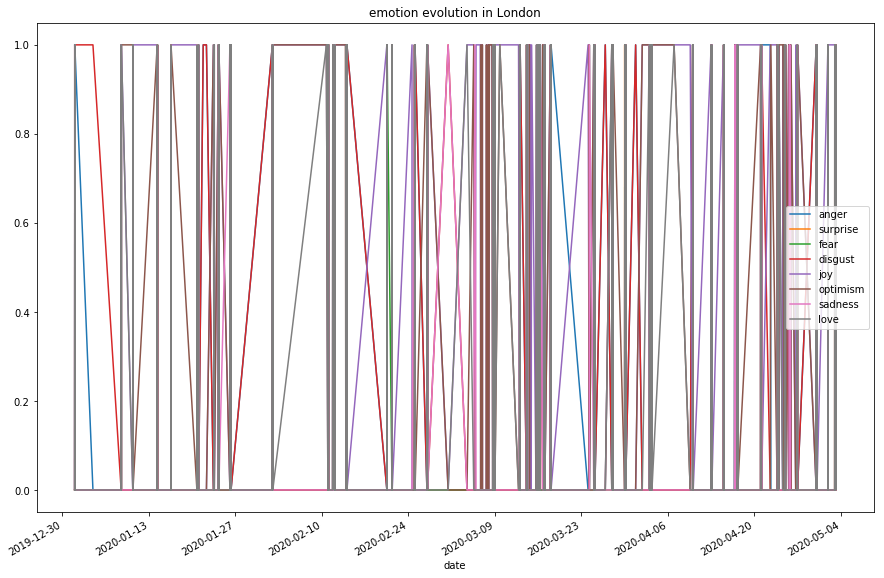

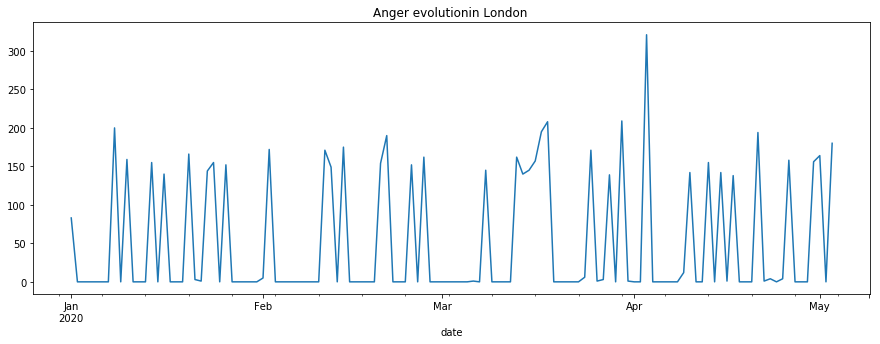

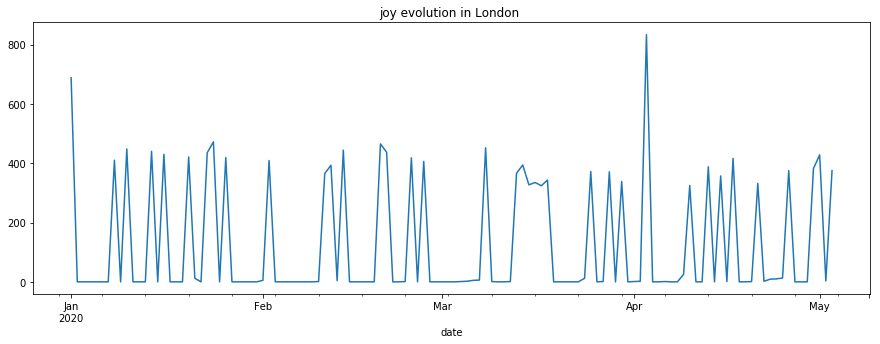

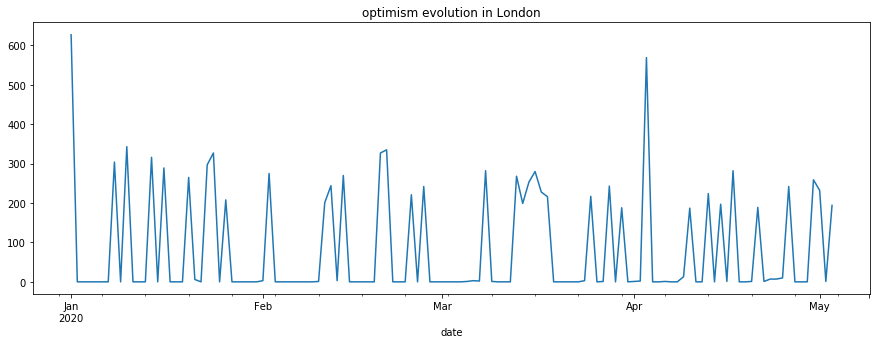

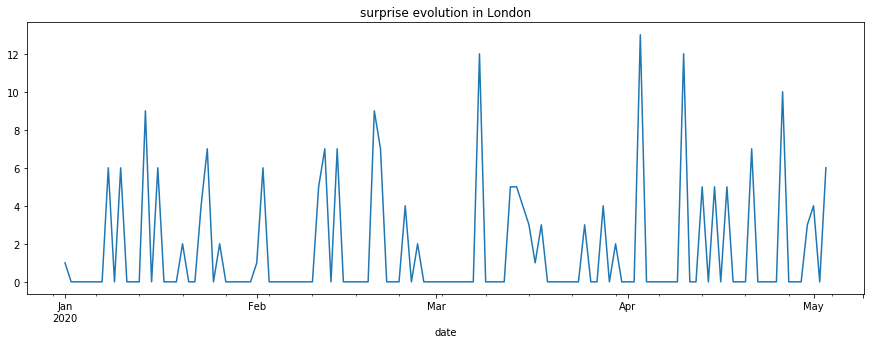

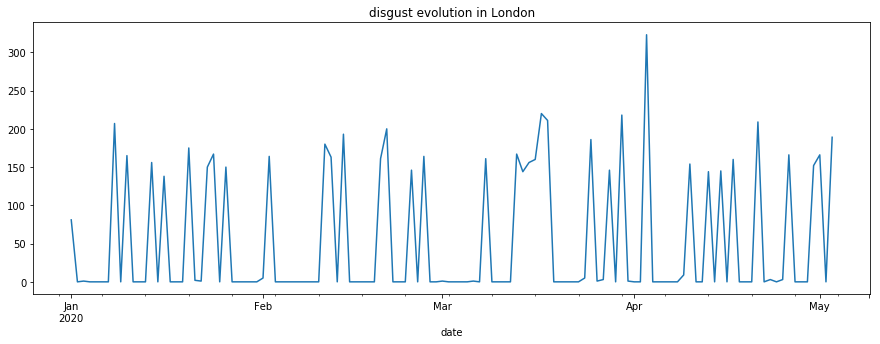

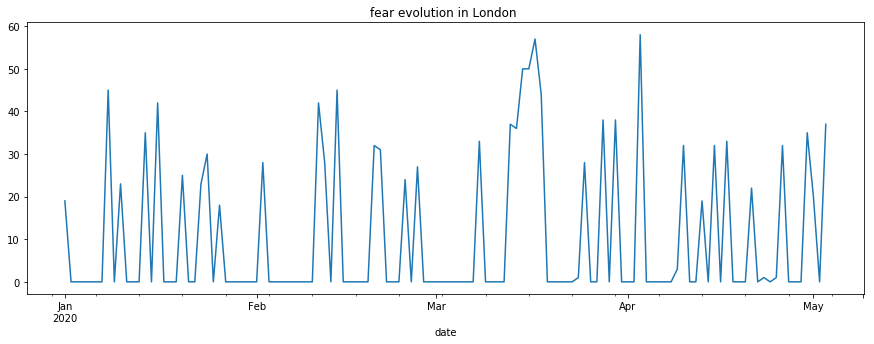

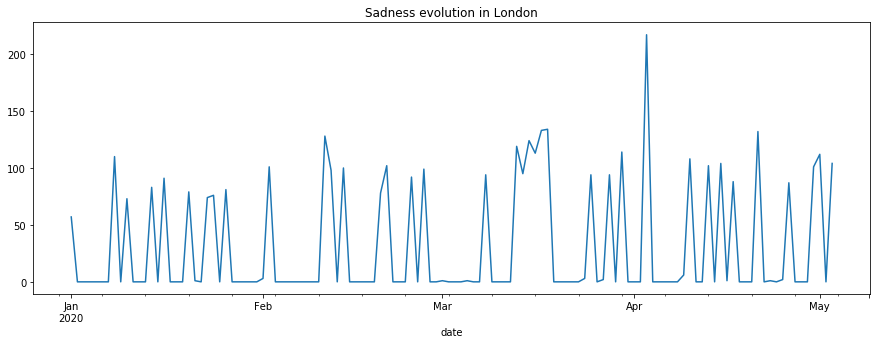

In [20]:
f0=plt.figure()
df.plot(figsize=(15,10))
plt.title("emotion evolution in London")

x1=df.anger.resample("1D").sum()
x2=df.joy.resample("1D").sum()
x3=df.optimism.resample("1D").sum()
x4=df.surprise.resample("1D").sum()
x5=df.disgust.resample("1D").sum()
x6=df.fear.resample("1D").sum()
x7=df.sadness.resample("1D").sum()
#df.plot(subplots=True,figsize=(15,10))
#df.plot(y=["joy", "anger","optimism","love","surprise","disgust","fear","sadness"], figsize=(15,10))

f1 = plt.figure()
x1.plot(figsize=(15,5))
plt.title("Anger evolutionin London ")
plt.savefig('Anger evolution in London_tr.png')

f2 = plt.figure()
x2.plot(figsize=(15,5))
plt.title("joy evolution in London ")
plt.savefig('joy evolution in London_tr.png')

f3 = plt.figure()
x3.plot(figsize=(15,5))
plt.title("optimism evolution in London")
plt.savefig('optimism evolution in London_tr.png')

f4 = plt.figure()
x4.plot(figsize=(15,5))
plt.title("surprise evolution in London")
plt.savefig('suprise evolution in London_tr.png')

f5 = plt.figure()
x5.plot(figsize=(15,5))
plt.title("disgust evolution in London")
plt.savefig('disgust evolution in London_tr.png')

f6 = plt.figure()
x6.plot(figsize=(15,5))
plt.title("fear evolution in London ")
plt.savefig('fear evolution in London_tr.png')

f7 = plt.figure()
x7.plot(figsize=(15,5))
plt.title("Sadness evolution in London")
plt.savefig('Sadness evolution in London_tr.png')

plt.show()


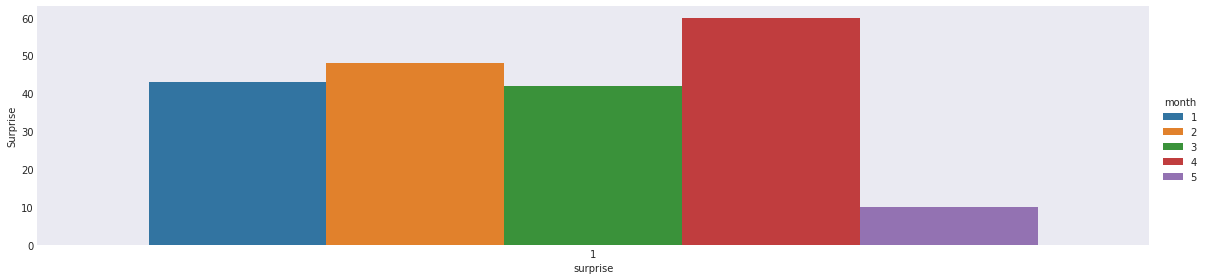

# Predictions by city

In [22]:
df_city = data_test.dropna(subset=['user_location'])
#New York
ny_search_values = ['nyc', 'new york', 'bronx', 'queens', 'manhattan', 'brooklyn', 'staten island']
df_city.loc[df_city.user_location.str.contains('|'.join(ny_search_values), case=False), 'city'] = 'New York'
#Berlin
search_values = ['berlin']
df_city.loc[df_city.user_location.str.contains('|'.join(search_values), case=False), 'city'] = 'Berlin' 
#Los Angeles
search_values = ['los angeles', 'hollywood', 'pasadena', 'beverly hills', 'santa monica', 'the valley', 'lax', 'westside', ]
df_city.loc[df_city.user_location.str.contains('|'.join(search_values), case=False), 'city'] = 'Los Angeles'
df_city.loc[df_city.user_location=='LA', 'city'] = 'Los Angeles'  
#London
search_values = ['london']
df_city.loc[df_city.user_location.str.contains('|'.join(search_values), case=False), 'city'] = 'London'
df_be=df_city[df_city.city=='Berlin']
df_la=df_city[df_city.city=='Los Angeles']
df_ny=df_city[df_city.city=='New York']
df_lo=df_city[df_city.city=='London']
df_city=df_be
df_city=df_city.append(df_la)
df_city=df_city.append(df_ny)
df_city=df_city.append(df_lo)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
df_city['month'] = pd.to_datetime(df_city['date'])
df_city['month'] = df_city['month'].dt.month.astype('str')

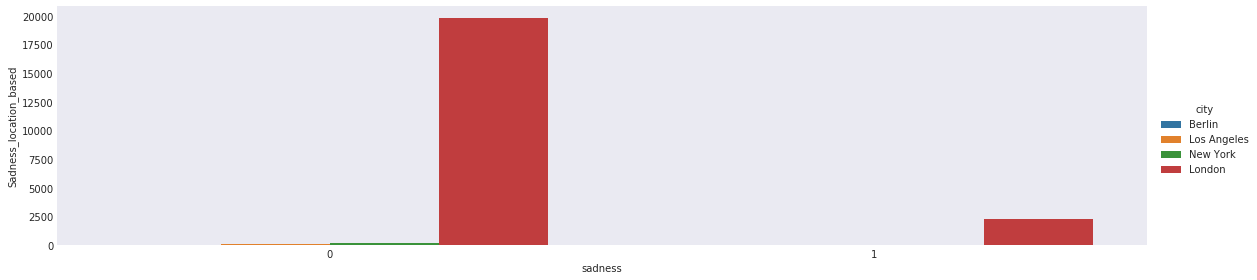

In [24]:
import seaborn as sns
#sns.displot(df_city, x="month", hue="user_location", stat="density")
with sns.axes_style('dark'):
    g = sns.factorplot("sadness", data=df_city, aspect=4.0, kind='count',
                       hue="city")
    g.set_ylabels('Sadness_location_based')

# Evaluating the model

In [27]:
### ----- Evaluate the model ------ ###
# Ready test data
test_y_joy = to_categorical(train_data['joy'])
test_y_anger = to_categorical(train_data['anger'])
test_y_fear = to_categorical(train_data['fear'])
test_y_disgust = to_categorical(train_data['disgust'])
test_y_optimism = to_categorical(train_data['optimism'])
test_y_love = to_categorical(train_data['love'])
test_y_sadness = to_categorical(train_data['sadness'])
test_y_surprise = to_categorical(train_data['surprise'])
test_x = tokenizer(
    text=train_data['text'].tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'anger': test_y_anger, 'joy': test_y_joy,  'fear':test_y_fear,'disgust':test_y_disgust,'optimism':test_y_optimism,'sadness':test_y_sadness,'surprise':test_y_surprise,'love':test_y_love }
)

214/214 [==============================] - 97s 451ms/step - loss: 1.4691 - anger_loss: 0.1700 - disgust_loss: 0.2557 - fear_loss: 0.1246 - joy_loss: 0.1724 - love_loss: 0.1276 - optimism_loss: 0.2352 - sadness_loss: 0.2537 - surprise_loss: 0.1298 - anger_accuracy: 0.9380 - disgust_accuracy: 0.8932 - fear_accuracy: 0.9623 - joy_accuracy: 0.9438 - love_accuracy: 0.9573 - optimism_accuracy: 0.9055 - sadness_accuracy: 0.9063 - surprise_accuracy: 0.9601
